# Media files containing structured fields in non-English languages

[T231952](https://phabricator.wikimedia.org/T231952) asks for a quarterly comparison of media files containing structured fields in non-English languages.

We'll gather both a snapshot of this, as well as look into the number of files having these added per quarter. Note that in the preliminary analysis of [T230581](https://phabricator.wikimedia.org/T230581), we found that very few of these edits are reverted. I'll therefore count both adds and removes to get a sense of how often captions are removed.  


<font color= red>_**Note that all metrics calculated in this version of the notebook are different than the previous versions due to the inclusion of December 2019 data that is now available in the Data lake. **_</font>

In [1]:
import pandas as pd
import numpy as np

import datetime as dt

from wmfdata import hive, mariadb

You are using wmfdata 0.1.0 (latest).

You can find the source for `wmfdata` at https://github.com/neilpquinn/wmfdata


In [3]:
## Load the RPython library so we can use R for graphs

%load_ext rpy2.ipython

In [4]:
%%R
library(ggplot2)
library(data.table)

## Configuration variables
**UPDATE 2020-01-17:** Modified Config variables snapshot and end_date to include data from December 2019 in all the metrics. Refer to [T242816](https://phabricator.wikimedia.org/T242816) 

In [5]:
wmf_snapshot = '2019-12'
start_date = '2019-01-01' # first date of caption edits
end_date = '2020-01-01' # last date of caption edits (exclusive)


In [ ]:
# Figured out a good testcase for caption edit comment identification:

'''SELECT rev_id, rev_timestamp, rev_user, rev_user_text, comment_text
FROM revision
JOIN revision_comment_temp
ON rev_id=revcomment_rev
JOIN comment
ON revcomment_comment_id = comment_id
WHERE rev_page = 61796201;'''

In [ ]:
## What structured data is available for that file?

'''
EXPLAIN SELECT revision.*, slots.*, content.*
# page excludes deleted pages (which are in archive)
FROM page
# joining on page_latest - we only care about most recent (not revdeleted) revision
INNER JOIN revision ON rev_id = page_latest
INNER JOIN slots ON slot_revision_id = page_latest
# mediainfo slot must contain actual content
INNER JOIN content ON slot_content_id = content_id AND content_size > 122
INNER JOIN slot_roles ON role_id = slot_role_id AND role_name = 'mediainfo'
WHERE page_id = 68860692
AND rev_deleted = 0
'''

In [ ]:
## The query above tells us that there's at least one slot assigned for that file.
## We should then be able to use the wbc_entity_usage table to identify what entities are in use.

'''
SELECT *
FROM wbc_entity_usage
WHERE eu_page_id = 68860692
'''

The issue here is that `wbc_entity_usage` shows the page has two labels, one in English and one in Portuguese. However, there's no Portuguese label on the page. This means that we can't use this to identify the current number of pages that have at least one non-English description. I also tried this with another page (`page_id = 10184478`) and that shows up with tons of slots assigned yet has only two descriptions on the current page (English and Chinese). This is not good.

In [ ]:
## Following up on https://phabricator.wikimedia.org/T238878, how many pages have a most recent
## revision that has been revdeleted.

'''SELECT count(*)
FROM page
JOIN revision
ON page_latest = rev_id
WHERE rev_deleted != 0;'''

## As of Dec 1, 2019, there were 80 pages with some type of revision deletion having taken place. Removing the rev_deleted clause
## doesn't really speed up the query, though, because it has to look up all the slots to identify those with > 122 bytes of content.

Let's investigate the amount of adds, modifications, and deletions of captions through `mediawiki_history`.  
***Note: Changed snapshot in the below query from 2019-10 to 2019-12 for [T242816] (https://phabricator.wikimedia.org/T242816) ***

In [6]:
caption_query = '''
SELECT
  SUM(IF(event_comment REGEXP "^...wbsetlabel-add", 1, 0)) AS num_adds,
  SUM(IF(event_comment REGEXP "^...wbsetlabel-set", 1, 0)) AS num_mods,
  SUM(IF(event_comment REGEXP "^...wbsetlabel-remove", 1, 0)) AS num_dels
FROM wmf.mediawiki_history
WHERE snapshot = "2019-12" 
AND wiki_db = "commonswiki"
AND event_entity = "revision"
AND event_type = "create"
AND event_timestamp >= "2019-01-01"
AND event_comment REGEXP "^...wbsetlabel-(add|set|remove):"
'''


In [7]:
label_counts = hive.run(caption_query)

In [8]:
label_counts

,num_adds,num_mods,num_dels
0,1773186,36805,11944


So additions outnumber modifications by two orders of magnitude, and deletions by more than two. There's about 1.5 million additions, are those mainly done by bots?
***Note: Changed snapshot in the below query from 2019-10 to 2019-12 for [T242816] (https://phabricator.wikimedia.org/T242816) ***

In [9]:
bot_caption_add_query = '''
SELECT
  SUM(IF(size(event_user_is_bot_by_historical) > 0, 1, 0)) AS num_bot_edits,
  SUM(IF(size(event_user_is_bot_by_historical) = 0, 1, 0)) AS num_nonbot_edits,
  SUM(IF(size(event_user_is_bot_by) > 0, 1, 0)) AS num_current_bot_edits
FROM wmf.mediawiki_history
WHERE snapshot = "2019-12"
AND wiki_db = "commonswiki"
AND event_entity = "revision"
AND event_type = "create"
AND event_timestamp >= "2019-01-01"
AND event_comment REGEXP "^...wbsetlabel-add:"
'''

In [10]:
botadded_captions_counts = hive.run([
    "SET mapreduce.map.memory.mb=4096",
    bot_caption_add_query
])

In [11]:
botadded_captions_counts

,num_bot_edits,num_nonbot_edits,num_current_bot_edits
0,170,1773016,167


OK, it looks like bots don't add captions. They might add other things (e.g. depicts statements, but they're not adding captions. Good to know.

## Number of files with non-English captions

In [12]:
## Bug-checking. I found that I need to double-escape "\" in order for it to work.
## So, for any special regexp-syntax like "\d", use "\\\\d". Maybe switch to "[0-9]" instead to make it more readable?

x = hive.run([
    "SET mapreduce.map.memory.mb=4096",
'''
SELECT event_comment
FROM wmf.mediawiki_history
WHERE snapshot = "{snapshot}"
AND wiki_db = "commonswiki"
AND event_entity = "revision"
AND event_type = "create"
AND event_timestamp >= "{start_date}"
AND event_timestamp < "{end_date}"
AND page_is_deleted = false -- only count live pages
AND page_namespace = 6 -- only count files
AND event_comment REGEXP "^...wbsetlabel-add:"
AND regexp_extract(event_comment, "^...wbsetlabel-add:\\\\d.(\\\\w+(-\\\\w+)?)", 1)
    NOT IN ("simple", "en")
LIMIT 250
'''.format(snapshot = wmf_snapshot, start_date = start_date, end_date = end_date)
])

In [13]:
x.head()

,event_comment
0,/* wbsetlabel-add:1|ru */ П.Р. Качкаев депутат...
1,/* wbsetlabel-add:1|vi */ Văn nghệ Hội đình là...
2,/* wbsetlabel-add:1|fr */ LA VIERGE ET L'ENFAN...
3,/* wbsetlabel-add:1|de */ Schloss Milotice Int...
4,/* wbsetlabel-add:1|pl */ Laboratorium fizyczn...


In [16]:
## Total number of files 

nonenglish_caption_count_query = '''
SELECT COUNT(DISTINCT page_id) AS num_pages
FROM wmf.mediawiki_history
WHERE snapshot = "{snapshot}"
AND wiki_db = "commonswiki"
AND event_entity = "revision"
AND event_type = "create"
AND event_timestamp >= "{start_date}"
AND event_timestamp < "{end_date}"
AND page_is_deleted = false -- only count live pages
AND page_namespace = 6 -- only count files
AND event_comment REGEXP "^...wbsetlabel-add:"
AND regexp_extract(event_comment, "^...wbsetlabel-add:\\\\d.(\\\\w+(-\\\\w+)?)", 1)
    NOT REGEXP "^simple|en|(en-.+)$" -- not Simple English, nor English, nor any variant of English
'''

In [17]:
nonenglish_caption_filecount = hive.run([
    "SET mapreduce.map.memory.mb=4096",
    nonenglish_caption_count_query.format(
        snapshot = wmf_snapshot,
        start_date = start_date,
        end_date = end_date
    )
])

In [18]:
nonenglish_caption_filecount

,num_pages
0,793470


## Number of files with English captions

In [19]:
## Total number of files with English captions

english_caption_count_query = '''
SELECT COUNT(DISTINCT page_id) AS num_pages
FROM wmf.mediawiki_history
WHERE snapshot = "{snapshot}"
AND wiki_db = "commonswiki"
AND event_entity = "revision"
AND event_type = "create"
AND event_timestamp >= "{start_date}"
AND event_timestamp < "{end_date}"
AND page_is_deleted = false -- only count live pages
AND page_namespace = 6 -- only count files
AND event_comment REGEXP "^...wbsetlabel-add"
AND regexp_extract(event_comment, "^...wbsetlabel-add:\\\\d.(\\\\w+(-\\\\w+)?)", 1)
    REGEXP "^simple|en|(en-.+)$" -- Simple English, English, or any variant of English
'''

In [20]:
english_caption_filecount = hive.run([
    "SET mapreduce.map.memory.mb=4096",
    english_caption_count_query.format(
        snapshot = wmf_snapshot,
        start_date = start_date,
        end_date = end_date
    )
])

In [21]:
english_caption_filecount

,num_pages
0,852148


## Number of files that had captions added

In [22]:
## Total number of files with English captions

all_caption_count_query = '''
SELECT COUNT(DISTINCT page_id) AS num_pages
FROM wmf.mediawiki_history
WHERE snapshot = "{snapshot}"
AND wiki_db = "commonswiki"
AND event_entity = "revision"
AND event_type = "create"
AND event_timestamp >= "{start_date}"
AND event_timestamp < "{end_date}"
AND page_is_deleted = false -- only count live pages
AND page_namespace = 6 -- only count files
AND event_comment REGEXP "^...wbsetlabel-add"
'''

In [23]:
all_caption_filecount = hive.run([
    "SET mapreduce.map.memory.mb=4096",
    all_caption_count_query.format(
        snapshot = wmf_snapshot,
        start_date = start_date,
        end_date = end_date
    )
])

In [24]:
all_caption_filecount

,num_pages
0,1486215


In [25]:
# Number of pages with both:

(nonenglish_caption_filecount['num_pages'] + english_caption_filecount['num_pages']
    - all_caption_filecount['num_pages'])

0    159403
Name: num_pages, dtype: int64

In [ ]:
## Can we extract the language using regexp_extract()?

'''
SELECT regexp_extract(event_comment, "^...wbsetlabel-add:\\d.(\\w+)", 1) AS label_lang
FROM wmf.mediawiki_history
WHERE snapshot = "2019-10"
AND wiki_db = "commonswiki"
AND event_entity = "revision"
AND event_type = "create"
AND event_timestamp >= "2019-01-01"
AND event_comment REGEXP "^...wbsetlabel-add:"
LIMIT 250
'''

## Yes, we can, and don't forget to add the LIMIT clause or you'll get 1.5 million rows back...
## Also, don't forget to double-escape things if running the query through Python.

## How quickly after creation does non-English captions get added?

In [26]:
## Time between page creation and edit 

time_to_caption_query = '''
SELECT unix_timestamp(event_timestamp) - unix_timestamp(page_creation_timestamp) AS time_to_caption
FROM wmf.mediawiki_history
WHERE snapshot = "{snapshot}"
AND wiki_db = "commonswiki"
AND event_entity = "revision"
AND event_type = "create"
AND event_timestamp >= "{start_date}"
AND event_timestamp <= "{end_date}"
AND page_is_deleted = false -- only count live pages
AND page_namespace = 6 -- only count files
AND event_comment REGEXP "^...wbsetlabel-add:"
AND regexp_extract(event_comment, "^...wbsetlabel-add:\\\\d.(\\\\w+(-\\\\w+)?)", 1)
    NOT REGEXP "^simple|en|(en-.+)$" -- not Simple English, nor English, nor any variant of English
'''

In [27]:
time_to_caption = hive.run([
    "SET mapreduce.map.memory.mb=4096",
    time_to_caption_query.format(
        snapshot = wmf_snapshot,
        start_date = start_date,
        end_date = end_date
    )
])

In [28]:
time_to_caption.head()

,time_to_caption
0,1
1,2
2,1
3,1
4,1


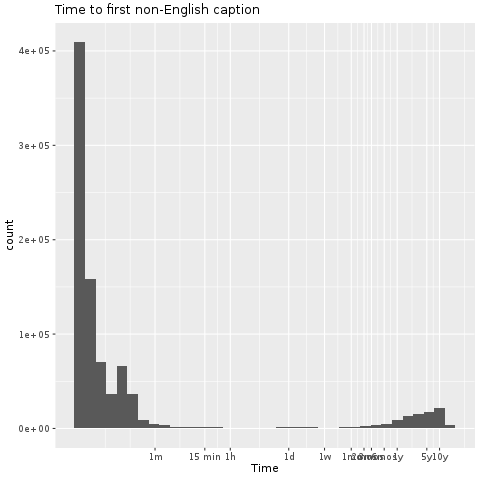

In [30]:
%%R -i time_to_caption

time_to_caption = data.table(time_to_caption)

g = ggplot(time_to_caption,
       aes(x = time_to_caption)) +
ggtitle("Time to first non-English caption") +
scale_x_log10(
  "Time",
  breaks=c(60, 15*60, 60*60, 24*60*60, 7*24*60*60, 30*24*60*60, 60*24*60*60, 90*24*60*60, 180*24*60*60,
           365*24*60*60, 5*365*24*60*60, 10*365*24*60*60),
  labels=c("1m", "15 min", "1h", "1d", "1w", "1mo", "2mos", "3mos", "6mos",
           "1y", "5y", "10y")) +
geom_histogram(binwidth = 0.25)

ggsave(plot = g, file = "graphs/time_to_non-English_caption.png",
       width = 9, height = 6, units = "in", dpi = "retina")
g

So non-English caption edits tend to be either shortly after a file is uploaded (within an hour, or maybe a day), and much later (more than a month).

## Quarterly measurements

Do we want a quarterly count of the number of files with non-English captions, or do we want a quarterly count of the number of files uploaded that had non-English captions added within say 30 days? I think it's the former. So, we take our query to get the count and use it three times, once for each quarter of 2019.

In [31]:
## Quarterly counts

nonenglish_first_caption_query = '''
SELECT page_id, MIN(event_timestamp) AS first_caption
FROM wmf.mediawiki_history
WHERE snapshot = "{snapshot}"
AND wiki_db = "commonswiki"
AND event_entity = "revision"
AND event_type = "create"
AND event_timestamp >= "{start_date}"
AND event_timestamp < "{end_date}"
AND page_is_deleted = false -- only count live pages
AND page_namespace = 6 -- only count files
AND event_comment REGEXP "^...wbsetlabel-add:"
AND regexp_extract(event_comment, "^...wbsetlabel-add:\\\\d.(\\\\w+(-\\\\w+)?)", 1)
    NOT REGEXP "^simple|en|(en-.+)$" -- not Simple English, nor English, nor any variant of English
GROUP BY page_id
'''

In [32]:
nonenglish_first_captions = hive.run([
    "SET mapreduce.map.memory.mb=4096",
    nonenglish_first_caption_query.format(
        snapshot = wmf_snapshot,
        start_date = start_date,
        end_date = end_date
    )
])

In [33]:
nonenglish_first_captions['first_caption_ts'] = pd.to_datetime(nonenglish_first_captions['first_caption'])

<font color= purple>**The metrics given below have been calculated with December 2019 snapshot. As a result, when compared to the previous version of the notebook, the values have slightly reduced because the query only consideres live pages and not deleted pages. Number of live pages over the months may have possibly reduced from Nov to Dec 2019, which could explain the drop. **</font>

Now we can count the number of pages with captions for each quarter. Through Q1 (end of March, 2019):

In [34]:
len(nonenglish_first_captions.loc[
    nonenglish_first_captions['first_caption_ts'] < dt.datetime(2019, 4, 1, 0, 0, 0)])

165837

Through Q2 (end of June, 2019):

In [35]:
len(nonenglish_first_captions.loc[
    nonenglish_first_captions['first_caption_ts'] < dt.datetime(2019, 7, 1, 0, 0, 0)])

386080

Through Q3 (end of September, 2019):

In [36]:
len(nonenglish_first_captions.loc[
    nonenglish_first_captions['first_caption_ts'] < dt.datetime(2019, 10, 1, 0, 0, 0)])

600259

Through Q4 (end of December, 2019):  
***Added for [T242816](https://phabricator.wikimedia.org/T242816) ***


In [37]:
len(nonenglish_first_captions.loc[
    nonenglish_first_captions['first_caption_ts'] < dt.datetime(2020, 1, 1, 0, 0, 0)])

793470